# <div style="text-align: center">18.335/6.337 Midterm Exam</div>
## <div style="text-align: center">Solution</div>
### <div style="text-align: center">Created by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## Import helper functions

This exam use some of the function written in the previous problem sets.  The relevant functions are defined in `helpers.jl` and imported here for later use.

In [1]:
include("helpers.jl");

## Problem 1.  Image compression via SVD [5 pts]

In this problem, we will use SVD to compress a grayscale image.  By viewing an image as a matrix whose entries are the brightness values (in grayscale) of pixels, we can calculate the SVD of the image matrix.  The SVD factors (not the image matrix) are the data to store in this compression scheme, and the size of the data can be reduced by dropping the last entries of the singular values and vectors, leading to data compression.  When loading this compressed set of data as an image, you multiply the truncated SVD factors back to get a low-rank approximation of the original image matrix.  

Note that this compression scheme is "lossy", because we cannot restore the original image matrix perfectly from the truncated set of singular values and vectors.

Though this compression procedure may look relatively straightforward, the devil is in the detail (as always).  Throughout this problem, we will consider the following grayscale image:

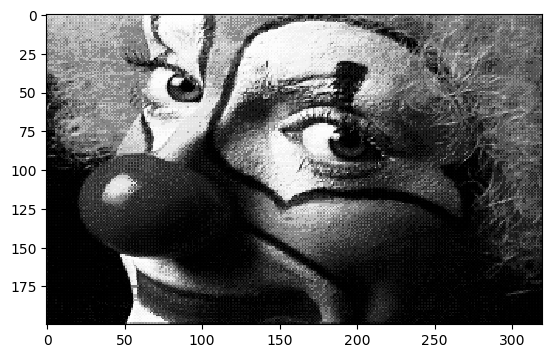

PyObject <matplotlib.image.AxesImage object at 0x1331ff550>

In [2]:
using JLD  # if not installed yet, execute Pkg.add("JLD") first
using PyPlot  # if not installed yet, execute Pkg.add("PyPlot") first

@load "clown.jld"  # load A
imshow(A, cmap="gray")

Grayscale pixel values are integers ranging from $0$ to $255 = 2^8 - 1$, so they are stored as 1-byte unsigned integers in the image matrix $A$:

In [3]:
eltype(A)

UInt8

Here, `8` in `UInt8` means 8 bits (= 1 byte).  Our image matrix `A` has $200\times320$ pixels, so this means `A` takes $200\times 320\times\text{ 1 byte} = 64000 \text{ bytes}$:

In [4]:
sizeof(A)

64000

(Note that `sizeof(A)` returns the number of bytes in `A`, and it is different from `size(A)` that returns the number of columns and rows of `A`.  Though `sizeof` serves the purpose here, you must be careful in using this function in general, because it does not always return what you expect.  For example, if the variable whose size is measured has a pointer field to an object "outside" the variable (in the heap), then `sizeof` does not measure the outside memory assigned to the object.)

The problem of using SVD for the purpose of image compression is two-fold.  First, in the reduced (not truncated) SVD $A = U \hat{\Sigma} \hat{V}^*$ (note our $A$ is fat), $\hat{V}^*$ has the same shape as $A$, so storing all the $U$, $\hat{\Sigma}$, and $\hat{V}$ factors already requires storing more entries than $A$.  This implies that you have to truncate quite a bit to achieve any space savings at all, because no truncation leads to a negative space savings, rather than zero space savings.

However, there is a more serious problem: $U$, $\hat{\Sigma}$, and $\hat{V}$ are floating-point matrices.  By default, Julia's `svd` returns double-precision floating-point arrays, whose each entry takes 8 bytes:

In [5]:
U, σ, V = svd(A);
eltype(V)

Float64

Here, `64` in `Float64` means 64 bits (= 8 bytes).  Therefore, each entry of the matrix factors $U$, $\hat{\Sigma}$, and $\hat{V}$ takes 8 times more memory than each entry of $A$.  For example, $\hat{V}$, which has the same shape as $A$, takes 8 times more memory than $A$:

In [6]:
sizeof(V)

512000

This is not ideal for compression.  So, we would want to store $U$, $\hat{\Sigma}$, and $\hat{V}$ in a more economical floating-point format *without* sacrificing accuracy.  Julia supports three floating-point types:

- `Float64` (8 bytes; double precision)
- `Float32` (4 bytes; single precision)
- `Float16` (2 bytes; half precision)

The `UInt8` integers ranging from 0 to 255 have up to 3 significant digits, and `Float16` has more than 3 significant digits according to [this Wikipedia article](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). Therefore, `Float16` seems sufficiently precise for storing $U$, $\hat{\Sigma}$, and $\hat{V}$.

### Assignment 1.1.  `compress_img` [2 pts]

Complete `compress_img(A, k)` below that returns $X$ and $Y$ such that $B = X Y$ is the rank-$k$ approximation of the image matrix $A$.

Requirements:

- In addition to the constructed $X$ and $Y$, also return the 2-norm error in $B$: `err` $= \frac{\norm{B-A}_2}{\norm{A}_2}$.
- Perform SVD only once inside the function.  In other words, do not perform additional SVDs in order to calculate `err`.
- The actual output matrices `X` and `Y` should be the `Float16` approximation of $X$ and $Y$.
- Write the code such that it can handle both fat and skinny $A$.

Hints:

- Even though $U$ and $V$ factors of SVD are complex in general, you can assume that they are real for real $A$.  (This is true, and in fact not very difficult to prove, though you don't have to prove this here.)
- `Float16.(F)` produces the `Float16` approximation of a matrix `F`.
- If you ever need to create diagonal matrices, you can use `diagm`.  (However, you don't have to use this function: there are many different—even better—ways to achieve the same result.)
- You will need to construct $X$ and $Y$ from the SVD factors $U$, $\Sigma$, $V$.  What numerical problem do you expect during this construction (in particular considering $X$ and $Y$ are `Float16`) and how can you avoid it?  (You don't have to provide the answer to this question.)

***Solution.***

In what follows, $U_{:,1:k}$, $\Sigma_{1:k,1:k}$, $V_{:,1:k}$ will be denoted simply by $U_k$, $\Sigma_k$, $V_k$. 
The rank-$k$ approximation of $A$ is $\tilde{A} = U_k \Sigma_k {V_k}^*$ and we want to express it as a product between two matrices $X$ and $Y$.  The most straightforward ways to construct $X$ and $Y$ seem to be either
$$
X = U_k \Sigma_k\;, \;\; Y = {V_k}^*,
$$
or
$$
X = U_k\;, \;\; Y = (V_k \Sigma_k)^*.
$$

However, casting such defined $X$ and $Y$ into `Float16` arrays can lead to *overflow* for some image $A$, because the maximum representable value in `Float16` is 65504—a rather small value—according to [this Wikipedia article](https://en.wikipedia.org/wiki/Half-precision_floating-point_format) given in the introduction part of this problem.  To see when overflow could happen, first note that the maximum singular value is $\sigma_1 = \max_{\norm{x}_2 = 1} \norm{A x}_2$.  Therefore, if an $m\times m$ square image $A$ is all-white (i.e., all pixels have a value 255), then for $x = \frac{1}{\sqrt{m}} [\,\underbrace{1\;\cdots\;1}_m\,]^*$ with $\norm{x}_2 = 1$ we have $y = A x = 255\sqrt{m}\;[\,\underbrace{1\;\cdots\;1}_m\,]^*$ and thus $\sigma_1 \ge \norm{y}_2 = 255m$.  This means $m \ge 257$ leads to $\sigma_1$ greater than 65504.  

Of course, when such a large $\sigma_1$ is multiplied with the entries of $U$ or $V$, the value becomes less than 65504 because the entries of $U$ and $V$ are usually less than $1$.  Therefore, in most cases defining $X$ and $Y$ as above does not cause any problem.  Still, by choosing a sufficiently large $m$, we can make $\sigma_1$ large enough to cause overflow while casting $X = U_k \Sigma_k$ or $Y = (V_k \Sigma_k)^*$ into `Float16`.  Check [this Wikipedia article](https://en.wikipedia.org/wiki/List_of_largest_photographs#Conventional_digital_photograph_(panorama) to see how large $m$ can be in some of the largest digital photographs.

Therefore, safer definitions of $X$ and $Y$ that are less susceptible to overflow are $X = U_k {\Sigma_k}^{1/2}$ and $Y = (V_k {\Sigma_k}^{1/2})^*$, where ${\Sigma_k}^{1/2}$ is the diagonal matrix with ${\sigma_i}^{1/2}$'s as the diagonal entries.  In these definitions, ${\sigma_1}^{1/2}$ that is much smaller than the large $\sigma_1$ is multiplied to the entries of $U$ and $V$, so $X$ and $Y$ are less susceptible to overflow when casted to `Float16`.

The relative error in $\tilde{A} = X Y$ is
$$
\frac{\norm{\tilde{A} - A}_2}{\norm{A}_2} = \frac{\sigma_{k+1}}{\sigma_1}.
$$
Evaluating the left-hand side directly using `norm` will perform two additional SVDs, because evaluating the 2-norm of a matrix requires one SVD.  Therefore, the relative error must be calculated using the right-hand-side formula in order to avoid additional SVDs.  

Note that $\sigma_{k+1}$ is not defined for $k = \min\{m,n\}$.  However, the error is $0$ when $k = \min\{m,n\}$, so $\sigma_{k+1}$ should be defined $0$; see Thm. 5.8.

**Grading.**

- 0.5 pts for constructing $X$ and $Y$ with one of the three methods discussed above.
- Additional 0.5 pts for constructing $X$ and $Y$ with ${\Sigma_k}^{1/2}$. 
- Additional 0.5 pts for calculating the error as $\frac{\sigma_{k+1}}{\sigma_1}$ without explicitly evaluating $\frac{\norm{X Y - A}_2}{\norm{A}_2}$.
- Additional 0.5 pts for calculating the error correctly for $k = \min\{m,n\}$ by considering the fact that $\sigma_{k+1}$ must be $0$ in that case.

In [7]:
function compress_img(A, k)
    m, n = size(A)
    p = min(m,n)
    
    U, σ, V = svd(A)
    
    err = k==p ? 0.0 : σ[k+1]/σ[1]

    X = Float16.(U[:,1:k]' .* .√σ[1:k])'  # equivalent to Float16.(U[:,1:k]*diagm(.√σ[1:k]))
    Y = Float16.(V[:,1:k]' .* .√σ[1:k])  # equivalent to (Float16.(V[:,1:k]*diagm(.√σ[1:k])))'

    return X, Y, err
end

compress_img (generic function with 1 method)

### Assignment 1.2.  `rank4ss` [1 pt]

You must have a much better understanding of this compression scheme after the previous assignment.  Now, let's calculate the number $k$ of the singular values and vectors to keep in order to achieve a given space savings.

Space savings is a metric that measures the memory reduction rate by compression, and defined as $1 - (\text{compressed size}/\text{original size})$.  If you are interested in space savings and related metrics, see [this article](https://en.wikipedia.org/wiki/Data_compression_ratio#Definitions).

Complete `rank4ss(A, tss)` below that calculates the *largest* rank $k$ to use in `compress_img` that achieves the space savings of at least `tss` (target space savings) for the original image matrix $A$.

Requirements:

- In addition to the calculated $k$, also return `ss`, the actual space savings achieved by using $k$ in `compress_img`.  (However, do not call `compress_img` or perform SVD in `rank4ss`.)
- Make sure to return an integer-type variable `k`.  In other words, when your calculated $k$ is $10$, return $10$ instead of $10.0$.  (If you don't, you will have a trouble in the next assignments.)  You can cast a floating point number `f` to the corresponding integer by `Int(f)`.
- Make sure to return $k$ within a valid range for the given $A$.  In other words, $k$ must be between $0$ and $\min\{m,n\}$, inclusive, for $A \in \Cmat{m}{n}$.  
    - This means we can fail to achieve the space savings of at least `tss` in some cases. For example, the maximum achievable space savings is $100\%$, so `tss = 2.0` should return `k = 0` and `ss = 1.0`.
- Using $k = \min\{m,n\}$ in `compress_img` means no truncation, so you may think that $k = \min\{m,n\}$ should be returned for zero space savings (`tss = 0`).  This is not true, because without truncation $X$ and $Y$ take more memory (corresponding to a *negative* space savings) than the original image $A$, as discussed in the introduction part of this problem.  
    - This means your code should be capable of handling negative `tss`.

***Solution.***

For a given $k$, $X$ is $m\times k$ and $Y$ is $k\times n$.  Because each entry of $X$ and $Y$ is a 2-byte `Float16`, storing $X$ and $Y$ takes $2k(m+n)$ bytes.  On the other hand, because each entry of $A$ is a 1-byte `UInt8`, storing $A$ takes $mn$ bytes.  Therefore, the space savings for a given $k$ is

$$
SS = 1 - \frac{2k(m+n)}{mn}.
$$

We would like to find the largest integer $k$ that achieves a given target space savings $TSS$ or more.  This means

$$
TSS \le SS  \Longleftrightarrow k \le \frac{mn}{2(m+n)}(1 - TSS) .
$$

Therefore, the desired $k$ is basically the largest integer $k$ that satisfies the above inequality.  However, such calculated $k$ may lie outside the valid range of $0 \le k \le p = \min\{m,n\}$.  In that case $k$ must be modified to the closest boundary value ($0$ or $p$).

Once $k$ in determined, the corresponding space savings can be calculated using the forumla for $SS$.

**Grading.**

- 0.5 pts for calculating $k$ and $SS$ correctly for general cases.
- Additional 0.5 pts for keeping $k$ within the valid range.

In [9]:
function rank4ss(A, tss)
    m, n = size(A)
    p = min(m, n)
    
    k = Int(floor((1-tss)*m*n / 2(m+n)))  # maximum k giving tss
    k = max(min(k,p), 0)  # bring k into valid range
    
    ss = 1.0 - 2k*(m+n)/(m*n)
        
    return k, ss
end

rank4ss (generic function with 1 method)

### Assignment 1.3.  `expand_img` [1 pt]

Complete `expand_img(X, Y)` below that constructs an image matrix $B$ out of $X$ and $Y$ generated by `compress_img` written above.  

Requirements:

- The output matrix `B` should be a `UInt8` matrix.

Hints:

- `UInt8.(F)` casts a floating-point matrix `F` into a `UInt8` matrix, but for this to work the entries of `F` must be rounded to unsigned integers first.
- When $X$ and $Y$ are constructed without truncation ($k = \min\{m,n\}$ in `compress_img`), the users would expect a perfect recovery of the original image by `expand_img`.  If you don't get a perfect recovery, you will need to check your `compress_img` and `expand_img`.

***Solution.***

Before $B$ is constructed as $X Y$, the `Float16` $X$ and $Y$ must be casted into `Float64`.  Otherwise you will not get desired accuracy in $B$.

Once $B = XY$ is constructed, you must cast the result into `UInt8`.  For this, you have to round the entries of $B$ into integers using `round`.  However, you will find that some entries of $B$ are negative and remain negative after rounding.  Because `UInt8` numbers must be nonnegative, you must replace those negative values with 0, which is the closest `UInt8` number to the negative values.

**Grading.**

- 0.5 pts for evaluating $XY$ after casting $X$ and $Y$ to `Float64`.
- Additional 0.5 pts for casting $B$ into `UInt8` after handling negative entries correctly.

In [11]:
function expand_img(X, Y)
    B64 = Float64.(X) * Float64.(Y)
    B = UInt8.(max.(0, round.(B64)))

    return B
end

expand_img (generic function with 1 method)

### Assignment 1.4.  Compression and expansion in action [1 pt]

Write a short script that does the followings:

- Compress our image $A$ into $X$ and $Y$ with `compress_img`. Perform this compression such that your reconstructed image in the next step has the best image quality while $X$ and $Y$ achieve at least a $60\%$ space savings.
- Reconstruct the image with `expand_img` from the compressed data $X$ and $Y$.
- Display:
    - the reconstructed image $B$,
    - the actual space savings you achieved (returned by `rank4ss`),
    - the expected error in $B$ (returned by `compress_img`), and 
    - the actual error in the reconstructed image (calculated by directly evaluating $\frac{\norm{B-A}_2}{\norm{A}_2}$).

***Solution.***

See the code block below.  Points will be deducted if some conditions are not satisfied.

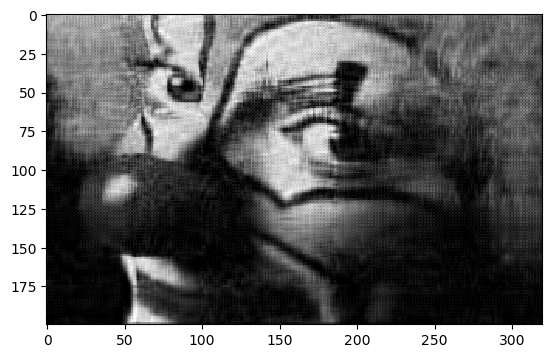

space savings = 0.61
error (expected) = 0.035406190000033
error (observed) = 0.034463855342424195


In [15]:
tss = 0.6
k, ss = rank4ss(A, tss)
X, Y, err = compress_img(A, k)
B = expand_img(X, Y)
imshow(B, cmap="gray")
println("space savings = $ss")
println("error (expected) = $err")
println("error (observed) = $(norm(float(B)-float(A))/norm(A))")

## Problem 2.  Compensation of the effect of input and output scramblings

Suppose you have a communication channel from Point $a$ to Point $b$.  This communication channel is *linear*, i.e., the output signal is a linear transformation of the input signal.  Unfortunately, this channel is experiencing some signal scrambling actions at the intput and output ends.  The goal of this problem is to find some filter that compensates these input and output scramblings, such that you measure the output signal as close to the input signal as possible.

Let's assume that the scrambling acions at the input and output ends can be represented by linear transformations $A$ and $B^*$, where $B$ is conjugate-transposed for convenience. Then, our goal is to find a linear transformation $X$ such that $B^* X A \approx I$.  Assume the input and output signals have $m$ entries.  Then $A\in\Cmat{q}{m}$, $B\in\Cmat{p}{m}$, and $X\in\Cmat{p}{q}$ for some $p$ and $q$.

### Assignment 2.1.  Perfect compensation [1 pt]

Let's think about when we can achieve perfect compensation $B^* X A = I$.  The equation provides us with $m^2$ entrywise equality constraints, while we have $p q$ unknown entries to determine in $X$.  Therefore, the problem becomes underdetermined and likely to have exact solutionts when we have more unknowns than constraints, i.e., $p q > m^2$.

Now, consider a case where both $A$ and $B$ are skinny ($p>m$ and $q>m$).  This is a simple case that satisfies $p q > m^2$.  For simplicity, assume additionally that $A$ and $B$ are both full-rank.  

Under these assumptions, derive an expression for one $X$ that satisfies $B^* X A = I$.  (Hint: SVDs.)

***Solution.***

Consider the reduced SVDs $A = \hat{U}_a \hat{\Sigma}_a {V_a}^*$ and $B = \hat{U}_b \hat{\Sigma}_b {V_b}^*$.  Substituting these expressions in $B^* X A = I$, we have
$$
V_b \hat{\Sigma}_b \hat{U}_b^* X \hat{U}_a \hat{\Sigma}_a {V_a}^* = I\;  \Longleftrightarrow\; \hat{U}_b^* X \hat{U}_a = \hat{\Sigma}_b^{-1} {V_b}^* V_a \hat{\Sigma}_a^{-1},
$$
because $\hat{\Sigma}_a$, $\hat{\Sigma}_b$, $V_{a}$, and $V_b$ are all square and full-rank, and the latter two are unitary.  

However, we cannot conclude from the last expression that 
$$
X = \hat{U}_b \hat{\Sigma}_b^{-1} {V_b}^* V_a \hat{\Sigma}_a^{-1} \hat{U}_a^*.
$$
Neither $\hat{U}_b \hat{U}_b^*$ nor $\hat{U}_a \hat{U}_a^*$ is an identity, so multiplying $\hat{U}_b$ and $\hat{U}_a^*$ to the left and right of $\hat{U}_b^* X \hat{U}_a$ does not produce the above $X$.  Still, by inspection we can verify the above $X$ satisfies $\hat{U}_b^* X \hat{U}_a = \hat{\Sigma}_b^{-1} {V_b}^* V_a \hat{\Sigma}_a^{-1}$.  Therefore, the above $X$ is one solution of this underdetermined problem.

Noticing $V_a \hat{\Sigma}_a^{-1} \hat{U}_a^*$ is the pseudoinverse of $A$ and $\hat{U}_b \hat{\Sigma}_b^{-1} {V_b}^*$ is the pseudoinverse of $B^*$, we can simplify the expression of $X$ into
$$
X = (B^*)^+ A^+,
$$
but obtaining this expression is not required for receiving the full mark.

Also note that among infinitely many possible solution of this underdetermined problem, the above $X$ is the one with the least Frobenius norm.  Proving this is not required for receiving the full mark.

**Grading.**

- 0.5 pts for figuring out the correct form of $X$.
- 0.5 pts for not incorrectly assuming $\hat{U}_a \hat{U}_a^*$ and $\hat{U}_b \hat{U}_b^*$ are identity matrices.

### Assignment 2.2.  Best compensation [2 pts]

Now, consider a more difficult case where both $A$ and $B$ are fat.  We have less unknowns than constraints in this case, so perfect compensation will not be always possible.  So, let's try to find the best compensator $X$ that makes $B^* X A$ as close to $I$ as possible.

We would like to measure the "closeness" between matrices by the Frobenius norm $\norm{\cdot}_F$.  Then, our problem is to find $X$ that minimized $\norm{I - B^* X A}_F$.

**(a) [1 pt]** Devise a way to find the best compensator $X$ by solving a least squares problem.

***Solution.***

To evaluate the Frobenius norm of $I - B^* X A$, we need to know the $(i,j)$ entry of the matrix.  The $(i,j)$ entry of the matrix is 
$$
\delta_{ij} - {b_i}^* X a_j = \delta_{ij} - \left[
\begin{array}{ccc}
{b_i}^* x_1 & \cdots  & {b_i}^* x_q \\
\end{array}
\right] a_j = \delta_{ij} - (a_{1j}{b_i}^*x_1+\cdots+a_{qj}{b_i}^*x_q) = \delta_{ij} - \left[
\begin{array}{ccc}
 a_{1j} {b_i}^* & \cdots  & a_{qj} {b_i}^* \\
\end{array}
\right] \left[
\begin{array}{c}
 x_1 \\
 \vdots  \\
 x_q \\
\end{array}
\right],
$$
where $\delta_{ij}$ is the Kronecker delta.  For given $i$, this expression can be collectively written for $1 \le j \le m$
$$
e_i - \left[
\begin{array}{ccc}
 a_{11} {b_i}^* & \cdots  & a_{q1} {b_i}^* \\
 \vdots & \ddots  & \vdots \\
 a_{1m} {b_i}^* & \cdots  & a_{qm} {b_i}^* \\
\end{array}
\right] \left[
\begin{array}{c}
 x_1 \\
 \vdots  \\
 x_q \\
\end{array}
\right].
$$
Let $C = A^\top$.  Then $\left[\begin{array}{c}
 a_{k1} \\
 \vdots  \\
 a_{km} \\
\end{array}
\right] = c_k$, so the above expression is written
$$
e_i - \left[
\begin{array}{ccc}
 c_1 {b_i}^* & \cdots  & c_q {b_i}^* \\
\end{array}
\right]\left[
\begin{array}{c}
 x_1 \\
 \vdots  \\
 x_q \\
\end{array}
\right].
$$
Note that each $c_k {b_i}^*$ is a matrix.  Lastly, the above expression can be collectively written for $1 \le i \le m$
$$
\left[
\begin{array}{c}
 e_1 \\
 \vdots  \\
 e_m \\
\end{array}
\right] - \left[
\begin{array}{ccc}
 c_1 {b_1}^* & \cdots  & c_q {b_1}^* \\
 \vdots & \ddots  & \vdots \\
 c_1 {b_m}^* & \cdots  & c_q {b_m}^* \\
\end{array}
\right] \left[
\begin{array}{c}
 x_1 \\
 \vdots  \\
 x_q \\
\end{array}
\right].
$$
The last expression is a length-$m^2$ column vector, and each of its $m^2$ entries is one of the entry of the matrix $I - B^*X A$.  This means that the Frobenius norm of $I - B^* X A$ is the 2-norm of the above column vector.  Therefore, we can find $X$ minimizing the Frobenius norm of $I - B^* X A$ by solving the least squares problem of minimizing the 2-norm of the above column vector.

**(b) [1 pt]** Prove that the system matrix of the least squares problem you solve in Part (a) is full-rank.

***Solution.***

The system matrix of the above constructed least squares problem is $m^2$-by-$pq$ and therefore skinny.  A skinny matrix is full-rank when its nullity is 0.  Therefore, we need to show that the zero vector is the only element of the nullspace of the system matrix.

For $\left[\begin{array}{c}
 x_1 \\
 \vdots  \\
 x_q \\
\end{array}
\right]$ to be in the nullspace, it must satisfy
$$
\left[
\begin{array}{ccc}
 c_1 {b_i}^* & \cdots  & c_q {b_i}^* \\
\end{array}
\right]\left[
\begin{array}{c}
 x_1 \\
 \vdots  \\
 x_q \\
\end{array}
\right] = c_1 ({b_i}^* x_1) + \cdots + c_q ({b_i}^* x_q) = 0
$$ for all $i$.  Because $C = A^\top$ is skinny and full-rank, $c_1, \ldots, c_q$ are linearly independent, so the above condition is satisfied if and only if ${b_i}^* x_1 = \cdots {b_i}^* x_q = 0$.  This can be collectively written for all $i$
$$
B^*x_1 = \cdots = B^* x_q = 0.
$$
This means all the $x_1, \ldots, x_q$ belong to the nullspace of $B^*$.  Because $B^*$ is skinny and full-rank, the zero vector is the only element of its nullspace.  Therefore, we conclude $x_1 = \cdots = x_q = 0$, which proves that the nullity of the system matrix is 0.

### Assignment 2.3.  `best_compensator` [1 pt]

Complete `best_compensator` that constructs the best compensator $X$ for given fat and full-rank $A$ and $B$ using the method devised in the previous assignment.  Use the backslash operator `\` to solve the least squares problem.

***Soultion.***

There are many ways to construct the system matrix.  The most standard way would be to allocate memory for an $m^2$-by-$pq$ matrix and to fill its entries appropriately.  Here, we will see a rather compact (but not necessarily the most efficient) way that utilizes [comprehensions](https://docs.julialang.org/en/stable/manual/arrays/#Comprehensions-1) and `cat`.

In [16]:
function best_compensator(A, B)
    q, m = size(A)
    p = size(B, 1)

    C = A.'
    M = cat(1, [cat(2, [C[:,j]*B[:,i]' for j = 1:q]...) for i = 1:m]...)  # system matrix

    I = eye(m)
    d = I[:]  # RHS vector of least squares problem
    
    x = M\d
    X = reshape(x, p, q)
        
    return X
end

best_compensator (generic function with 1 method)

### Assignment 2.4.  `best_compensator` in action [1 pt]

Write a short script that applies `best_compensator` for the given $A$ and $B$ stored in `AB.jld`.  Print the relative error $\norm{I - B^* X A}_F / \norm{I}_F$ for the found $X$.  You can calculate the Frobenious norm of a matrix `M` by `vecnorm(M)`.  (Don’t be too surprised if you get a rather big error here: constructing a good compensator for $p q < m^2$ is difficult.)

In [18]:
using JLD

@load "AB.jld"

X = best_compensator(A, B)
m = size(A, 2)
I = eye(m)
err = vecnorm(B'*X*A-I)/vecnorm(I)
println("relative error = $err")

relative error = 0.7785459135743249


## Problem 3.  QR factorization with column pivoting [5 pts]

We discussed three methods to solve a least squares problem $\min_x \norm{b - A x}$: via the normal equation, via QR factorization, and via SVD.  We learned why the solution method via SVD, which is computationally most expensive, needs to be used when $A$ is rank-deficient.  What was also mentioned in class was using the backslash operator `\` of Julia is an alternative way to handle rank-deficient $A$, because `\` solves the least squares problem by internally performing QR factorization with column pivoting.  In this problem, we will modify our Householder QR factorization algorithm to perform column pivoting additionally.

The result of the QR factorization with column pivoting is written
$$
A P = Q R,
$$
where $P$ is a column permutation matrix.  In Julia notation, this can be written 
$$
A_{:,p} = Q R,
$$
where $p$ is a vector indicating the permuted column indices of $A$.  (If you don't know the meaning of this notation, please try `A = rand(4,3); p = [3,1,2]; B = A[:,p]` and compare `A` and `B`.)

The column permutation is carried out to make the diagonal entries of $R$ decrease in magnitude, i.e., 
$$
\left|r_{11}\right| \ge \cdots \ge \left|r_{kk}\right| > 0 = \left|r_{k+1,k+1}\right| = \cdots = \left|r_{nn}\right|.  
$$

This guarantees that the first $k$ columns of $Q$ are the orthonormal basis vectors of $\range(A)$ for a rank-$k$ matrix $A\in\Cmat{m}{n}$, even if $A$ is rank-deficient (i.e., $k<n$).  Note that this is not the case with the regular QR factorization.

How do we find the column permutation that achieves this?  You can easily determine the column to put at the front.  In the regular Householder QR factorization, the first column $x = a_1$ is transformed by $F x = e^{i\theta} \norm{x} e_1$ by the Householder reflection $F$.  Therefore, $r_{11} = e^{i\theta} \norm{x}$, and $\abs{r_{11}} = \norm{x} = \norm{a_1}$.  In other words, the magnitude of $r_{11}$ is the norm of the first column of $A$.  Therefore, for $r_{11}$ to have the largest magnitude, you just need to find the longest (in the 2-norm sense) column of $A$ and swap it with the original first column of $A$.

Then the permuration can be performed similarly for the remaining columns.  At Step $k$ of the Householder QR factorization, your workspace is $A_{k:m, k:n}$, where $A$ is partially triangularized up to the $(k-1)$th column.  Therefore, you need to find the longest column of $A_{k:m, k:n}$ and swap it with the $k$th column of $A$.

Based on this information, complete `house_pivoted!()` below that performs the Householder QR factorization with column pivoting.

The function takes two input arguments `V` and `A`: 
- `V` is a matrix of the same size as `A`, and
- `A` is square or skinny.

After execution of `house_pivoted!(V, A)`, 
- the lower-triangular portion of `V` stores the unit vectors $\hat{v}$ used to construct Householder reflectors, i.e., $V_{k:m,k} = \hat{v}_k$,
- `A` stores the $R$ factor of the full QR factorization of $A_{:,p}$,
- and the permutation vector $p$ such that $A_{:,p} = Q R$ is returned as the output.

Also, when you calculate the norms of $(n-k+1)$ columns in Step $k$, try to calculate them in an efficient manner, if possible.  (You can reuse the information of the norms calculated in the previous step.)

The body of `house_pivoted!` is already populated with the body of `house!` in the previous problem set, because `house_pivoted!` is a modification of `house!`.  You can use the code you wrote for the problem set if you want.

***Solution.***

The trick to calculate the norms of the columns of the matrix block in the workspace is as follows.  At Step 1, we need to calculate the norms of all the columns of $A$.  Keep the squares of these norms.  After Step 1, the first row (and also the first column) is removed from the workspace.  Therefore, the squared norms of the columns of the workspace matrix block is simply the norms kept in the previous space minus the absolute squares of the first row entries.  This way, the squared norm of each column is efficiently calculated with one absolute square and one subtraction, instead of adding the absolute squares of all the entries of the columns.  This procedure can be repeated similarly as the workspace reduces.

**Grading.**

- 4 pts for producing the correct result.
- Additional 1 pt for calculating the norms of the columns efficiently with the above described method or a similar method.

In [19]:
function house_pivoted!(V, A)
    m, n = size(A)
    assert(size(V)==(m,n))

    V .= 0  # initialize

    # Construct the candidates of squared diagonal entries.
    r² = sum(abs2, A, 1)
    p = collect(1:n)
    atemp = similar(A, m)

    for k = 1:n
        # Among the column k through n, find the one to be brought to the kth column.
        kp = k
        for j = k+1:n
            if r²[j] > r²[kp]
                kp = j
            end
        end
        
        # If the found column is not already the ith column, do the permutation to bring it to the ith column.
        if kp ≠ k
            p[k], p[kp] = p[kp], p[k]
            r²[k], r²[kp] = r²[kp], r²[k]

            # Permute columns of A
            A[:,k], A[:,kp] = A[:,kp], A[:,k]
        end

        x = @view A[k:m, k]
        
        # Construct sign(x₁) for exp(iθ) = -sign(x₁).
        s = sign(x[1])
        if s == 0
            s = 1.0
        end

        # Construct the kth Houreholder reflection vector.
        v = @view V[k:m, k]
        copy!(v, x)
        lx = norm(x)
        slx = s * lx
        v[1] += slx
        
        # Perform the Householder reflection to triangularize the kth column of A.
        lv = norm(v)
        if lv ≠ 0
            v ./= lv
            
            # Take care of the kth column of A.
            A[k+1:m, k] .= 0
            A[k,k] = -slx
            
            # Take care of the remaining columns of A.
            if k < n
                A[k:m, k+1:n] .-= v .* (2(v'*@view(A[k:m, k+1:n])))
            end
        end

        # Update the candidates of squared diagonal entries.
        for j = k:n
            r²[j] -= abs2(A[k,j])
        end
    end
    
    return p
end

house_pivoted! (generic function with 1 method)

### Validation of your implementation

Because this problem is a bit involved in terms of coding, the validation code is provided for you.  You are welcome to change the validation code to test your code differently.  (`formQhouse!` used below is defined in `helpers.jl` included at the beginning of this notebook.)

In [20]:
m, n = 10, 7
A = rand(Complex128, m, n)

R = copy(A)
V = similar(A)

p = house_pivoted!(V, R)

Q = eye(Complex128, m)
formQhouse!(V, Q)

println("Q* Q ≈ I?  $(Q'Q ≈ eye(m))")
println("QR ≈ A[:,p]?  $(Q*R ≈ A[:,p])")
println("rᵢᵢ decreasing?  $(issorted(abs.(diag(R)), rev=true))")

Q* Q ≈ I?  true
QR ≈ A[:,p]?  true
rᵢᵢ decreasing?  true


## Problem 4.  Arnoldi-like iteration for polynomial data fitting [5 pts]

When we have output measurements $b_1 = f(x_1), \ldots, b_m = f(x_m)$ for inputs $x_1, \ldots, x_m$, we can find the best polynomial of degree $n-1$ to which the measurement data fit by solving a least squares problem using the $m\times n$ Vandermonde matrix.

However, this Vandermonde matrix $V$ quickly becomes nearly rank-deficient as $n$ increases.  The reason is as follows.  Each column of $V$ represents a function $x^k$ for $0 \le k \le n-1$.  However, as $k$ increases, $x^k$ converges to a function that is completely zero for $\abs{x}<1$ and $\pm\infty$ for $\abs{x} > 1$.  This means that the columns of $V$ become increasingly similar for larger $k$'s, making $V$ nearly rank-deficient.  Then, the solution of the least squares problem via the *regular* QR factorization becomes inaccurate as we know.  (Of course, you can use SVD or QR factorization with column pivoting to handle rank deficiency properly, but these are more expensive than the regular QR factorization.)  For example, the following code shows that the $Q$ factor of $V$ calculated by MGS is no longer sufficiently unitary even for $n$ as small as $15$ (`vander` and `mgs` used below are defined in `helpers.jl` included at the beginning of this notebook):

In [ ]:
m, n = 1000, 15
x = linspace(0,1,m)
V = vander(x,n)
Q, R = mgs(V)
println("Q* Q ≈ I? $(Q'Q ≈ eye(n))")

In fact, we had a similar situation in the discussion of Krylov subspace methods.  When implementing the GMRES algorithm, we attempted to construct orthonormal basis vectors of the Krylov subspace by the Gram–Schmidt procedure, but because $A^k r_0$ became increasingly more aligned with increasing $k$, the Gram–Schmidt procedure suffered catastrophic cancellation.

To overcome this numerical difficulty, we used the Arnoldi iteration.  There, instead of orthogonalizing $A^n r_0$ against the previously constructed orthonormal basis vectors $q_1, \ldots, q_n$ to construct a new basis vector $q_{n+1}$, we orthogonalized $A q_n$.  

Similarly, we can construct a matrix $W$ whose columns represent *pre-orthogonalized* polynomials.  Like $q_1, q_2, \ldots, q_n$ of the Arnoldi iteration span the Krylov subspace spanned by $r_0, A r_0, \ldots, A^{n-1} r_0$, the columns $w_1, w_2, \ldots, w_n$ of $W$ are orthonomal but span $\range(V)$.  In order to construct an additional column to append to $W$, we can orthogonalize the column representing `x.^n` (the new column to append to $V$) against the pre-orthogonalized $w_1, \ldots, w_n$, but we can also orthogonalize `x.*`$w_n$.  Here, the operation `x.*` and the last orthonormal basis vector $w_n$ correspond to the multiplication of $A$ and the last orthonormal basis vector $q_n$ of the Krylov subspace, respectively.  The latter is numerically stabler way to construct the orthonormal basis vectors spanning $\range(V)$.

### Assignment 4.1.  `orthopoly!`  [2 pts]

Complete `orthopoly!(W, x, n)` below that fills the $(n+1)$th column of the $W$ matrix as illustrated above.  Here,

- `W` is the matrix $W\in\Cmat{m}{n_\max}$ whose first $n$ columns are already constructed,
- `x` is the column vector $x = \left[x_1 \;\; \cdots \;\; x_m\right]^\top$, and
- `n` satisfies $1 \le n < n_\max$.

The overall procedure is similar to the Arnoldi iteration, except that you use entrywise multiplication of $x$ instead of multiplication of $A$.

This code assumes that the first column of $W$ is already constructed: assume that the first column of $W$ is the normalized version of the first column of $V$.

In [21]:
function orthopoly!(W, x, n)
    v = @view W[:,n+1]
    v .= x .* @view(W[:,n])
    for j = 1:n
        w = @view W[:,j]
        r = w⋅v
        v .-= r.*w
    end
    normalize!(v)
    
    return nothing
end

orthopoly! (generic function with 1 method)

### Validation of your implementation

Because the solution to this assignment affects the later assignments, the validation code is provided here.

In [45]:
W = zeros(m,n)
W[:,1] = 1/√m
for j = 1:n-1
    orthopoly!(W, x, j)
end

println("W* W ≈ I?  $(W'W ≈ eye(n))")

W* W ≈ I?  true


## Assignment 4.2.  `fit_orthopoly!`  [2 pts]

Once $W$ is constructed, we can very easily find the polynomial to which the measurement data $(x_1, b_1), \ldots, (x_m, b_m)$ fit.  Now, the problem is to minimize $\norm{b - W y}$, but note that the columns of $W$ are already orthonormal.

Also, because `orthopoly!` construct $W$ incrementally, we can increase the number of columns of $W$ gradually until we have a sufficiently good fit.  Suppose $W_n$ is the $W$ matrix with $n$ columns, and $y_n$ is the length-$n$ solution vector.  Then, we want to find the smallest $n$ that satisfies $\frac{\norm{b - W_n y_n}}{\norm{b}} \le \tau$.

Complete `fit_orthopoly!(W, y, x, b, tol)` below that solves the above described problem.  Here,

- `W` is an uninitialized $m \times n_\max$ matrix whose first $n$ columns will store the $W_n$ matrix,
- `y` is a length-$n_\max$ vector whose first $n$ entries will store the solution $y_n$,
- `x` and `b` are the column vector $x = \left[x_1 \;\; \cdots \;\; x_m\right]^\top$ and $b = \left[b_1 \;\; \cdots \;\; b_m\right]^\top$, and
- `tol` is the tolerance $\tau$.

`fit_orthopoly!` will return the desired $n$ and $\frac{\norm{r_n}}{\norm{b}}$, where $r_n = b - W_n y_n$.

Also, like we tried to avoid matrix-vector multiplication in evaluating $r_n = b - A x_n$ in Krylov subspace methods, try to calculate $r_n = b - W_n y_n$ efficiently, if possible.

**Grading.**

- 1.5 pts for producing the correct result.
- Additional 0.5 pts for calculating $r_n$ by subtracting the vector $\left[y_n\right]_\text{end} \left[W_n\right]_\text{end}$ from $r_{n-1}$, instead of evaluating $r_n = b - W_n y_n$ directly.

In [43]:
function fit_orthopoly!(W, y, x, b, tol)
    m = length(x)
    nmax = size(W,2)
    W .= 0
    W[:,1] = 1/√m

    r = copy(b)
    lb = norm(r)
    lr = lb
    n = 0
    for n = 1:nmax
        w = @view W[:,n]
        y[n] = w⋅r
        r .-= y[n].*w
        lr = norm(r)
        if n==nmax || lr ≤ tol*lb
            break
        end
        orthopoly!(W, x, n)
    end
    
    return n, lr/lb
end

fit_orthopoly! (generic function with 1 method)

### Assignment 4.3.  `fit_orthopoly!` in action [1 pt]

Write a short script that uses `fit_orthopoly!` to find the smallest $n$ that fits $\cos(x)$ to a polynomial of degree $n-1$ 

- Perform the fitting in the interval $\left[0, 1\right]$ of $x$.  Use equally spaced 50 points from $x = 0$ to $x = 1$.
- Use a tolerance $\tau = 10^{-6}$.
- Print the found $n$ and the corresponding residual error $\frac{\norm{r_n}}{\norm{b}}$.

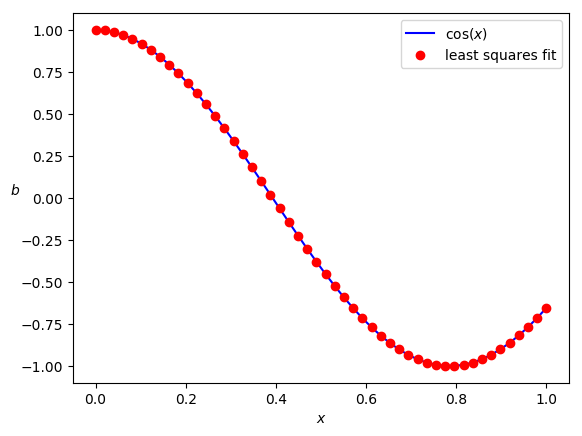

n = 10, ‖rₙ‖/‖b‖ = 1.9953437097278477e-7


In [44]:
using PyPlot

m = 50
nmax = 20
W = zeros(m, nmax)
y = zeros(nmax)

x = linspace(0, 1, m);
b = cos.(4*x);

tol = 1e-6
n, err = fit_orthopoly!(W, y, x, b, tol)

plot(x, b, "b-", x, W*y, "ro")
xlabel(L"x")
ylabel(L"b", rotation=0)
legend([L"\cos(x)", "least squares fit"])
println("n = $n, ‖rₙ‖/‖b‖ = $err")